# `Image Recognition Framework with CNN Model Trained on Image Net` 

# `e.g. Lets train a Convolutionary Neural Network classifier to identify the species of flowers!`  

----
# 0. Background 

The image classifier developed here can be implemented in an app to tell you about the flowers your camera is looking at. 

The model is trained on a dataset of [102 flower categories](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). This dataset is available for download [here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). 

The final product is a command line application ready to be deployed with a flower images of your choosing. Please feel free to use this framework to build your own image recognition application.

#### Approach: 

1. Import libraries
1. Set up training and validation data loaders
1. Load a pretrained CNN model layers and define new a fully connected final classification network layer
1. Train and save the model 
1. Load trained model
1. Test model
1. Apply model for inference
1. Sanity check


# [1] Set-up

#### 1.1 Import images data

In [6]:
# download data and unzip archive in Linux 
#!wget -N link.flower_data.zip;
#!unzip -o flower_data.zip;

#### 1.2 Import libraries

In [7]:
# Hide deprecation and user warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [8]:
# Import and configure visualization library 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
# Import data processing librabries 
import numpy as np
import pandas as pd 
from PIL import Image
import json

In [10]:
# Import PyTorch Deep Learning modules used in this notebook 
import torch 
from torchvision import transforms, models, datasets

#### 1.3 Check if GPU is available

In [11]:
# Check if gpu is available and designate 'device' accordingly 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# [2] Set up training and validation data loaders

We will normalize the means and standard deviations of the images color channels using values calculated from the `ImageNet` images database. The three color channel means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`. Normalizing by these values will shift the each color channel of the input image to be centered at 0 and range from -1 to 1.

#### 2.1 Define the training and validation image transforms

In [12]:
# Training images transform
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

# Valication imgaes transform -- without orintation transform since we want to evaluate the model with as is images   
valid_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

#### 2.2 Define the training and validation data loaders 

In [13]:
# Input data directory structure  
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Load the datasets with ImageFolder torch.datasets.ImageFolder module 
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=valid_transforms)

# Define the dataloaders using the training and validation image datasets and trainforms defined 
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle=True)

#### 2.3 Define image labels

We will also need a mapping from integer encoded categories to the actual names of the flowers found in the `cat_to_name.json` file 


In [14]:
# load the category number to name mapping file into a dictionary
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f); 

# print out some labels 
print({k: cat_to_name[k] for k in sorted(cat_to_name)[:10]})

{'1': 'pink primrose', '10': 'globe thistle', '100': 'blanket flower', '101': 'trumpet creeper', '102': 'blackberry lily', '11': 'snapdragon', '12': "colt's foot", '13': 'king protea', '14': 'spear thistle', '15': 'yellow iris'}


#### 2.4 Visualize sample input data

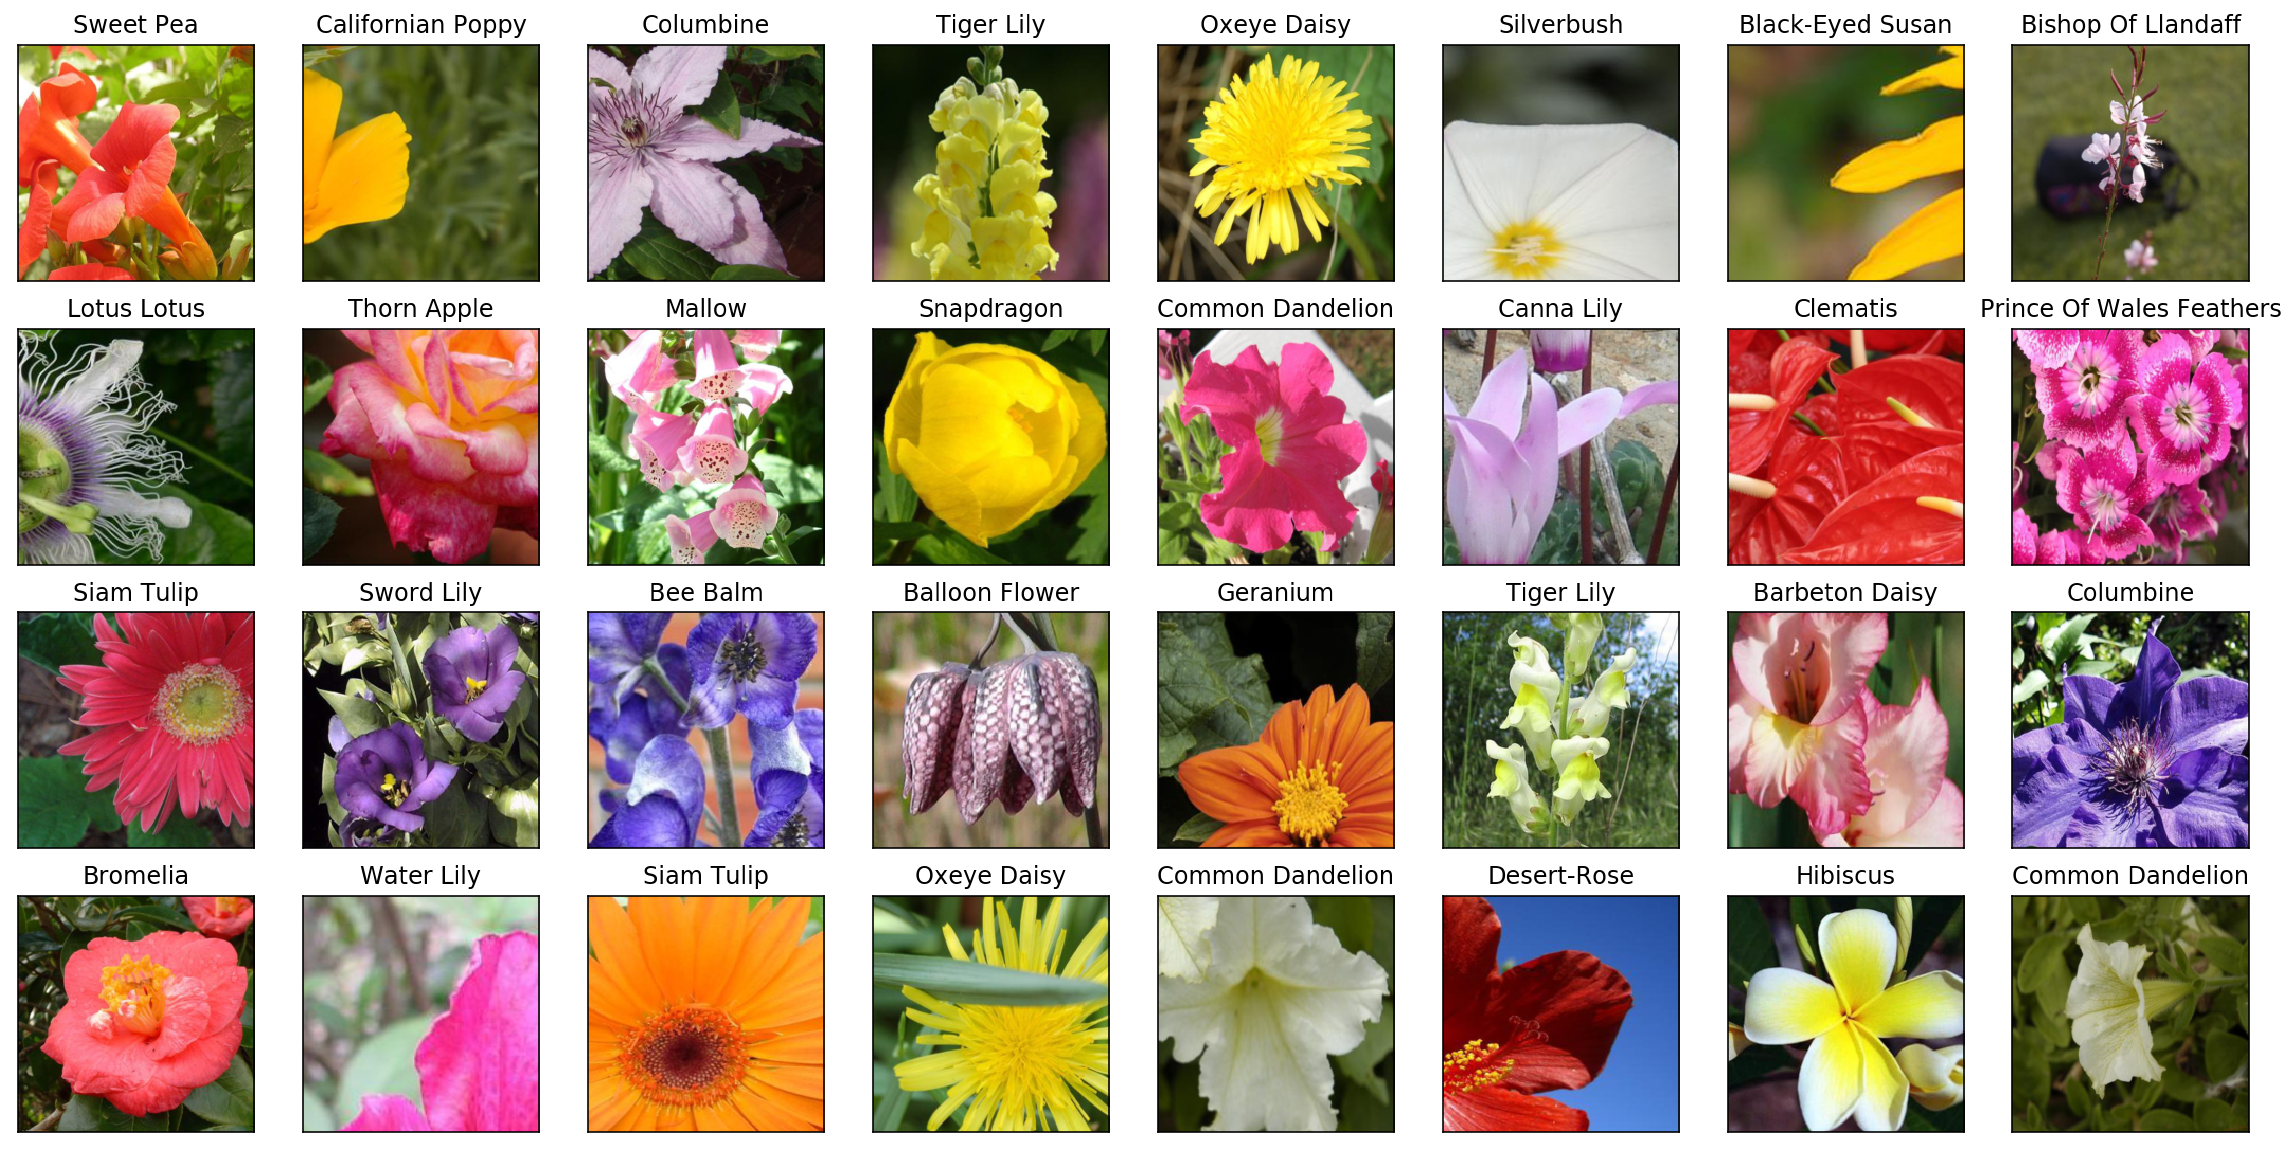

In [15]:
# define raw a data loader 
raw_data = datasets.ImageFolder(valid_dir, transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor(),]))
raw_loader = torch.utils.data.DataLoader(raw_data, batch_size=64, shuffle=True)

# obtain one batch of input images
dataiter = iter(raw_loader)
images, labels = dataiter.next()

# convert images to numpy for display
images = images.numpy() 
images = np.clip(images, 0, 1)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(32):
    ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(cat_to_name[str((labels[idx]+1).squeeze().numpy())].title())

# [3] Load pretrained CNN features and define a neural network classifier

We will use one of the pretrained models from `torchvision.models` to get the image features, "Freeze" CNN layers parameters so the net acts as a fixed feature extractor, and replace the last layer with a linear classifier of our own


#### 3.1 Choose and load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) and define a fully connected final classifier

In [19]:
def load_my_classifier(model=models.densenet121(pretrained=True)): 
    
    # freeze parameters to prevent backpropogation
    for param in model.parameters():
        param.requires_grad = False
    
    # load a pretrained model features and define a new classifier 
    model.classifier = torch.nn.Sequential(torch.nn.Linear(1024, 1024),
                                     torch.nn.ReLU(),
                                     torch.nn.Dropout(0.5),
                                     torch.nn.Linear(1024, 512),
                                     torch.nn.ReLU(),
                                     torch.nn.Dropout(0.5),
                                     torch.nn.Linear(512, 102),
                                     torch.nn.LogSoftmax(dim=1))
    
    # adding a mapping of classes to indecies for training data as part of model
    model.class_to_idx = train_data.class_to_idx
    model.to(device)
    
    return model

In [20]:
# load the new model
model = load_my_classifier(model=models.densenet121(pretrained=True))

#### 3.2 Choose and load a loss criterion and an optimizer function for training the classifier

In [21]:
# load criterion 
criterion = torch.nn.NLLLoss()

# load optimizer: we will train the classifier parameters, while feature parameters will remain frozen
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.002)

# [4] Train and save the model

In [22]:
def train_nn_classifier(device, train_loader, valid_loader, model, optimizer, criterion, epochs, valid_every):

    steps = 0
    train_loss = 0
    valid_loss = 0
    valid_loss_min = np.Inf 
   
    #### 4.1 Train the neural nerwork 
       
    for epoch in range(epochs):
        for images, labels in train_loader:
            steps += 1

            # transer imagesinputs and labels to the GPU if available 
            images, labels = images.to(device), labels.to(device)

            # forward 
            optimizer.zero_grad() # clear gradients from the previous training loop 
            logps = model.forward(images)
            loss = criterion(logps, labels)

            # backward 
            loss.backward()
            optimizer.step()

            # running training loss
            train_loss += loss.item()/valid_every 
              
            #### 4.2 Validate the training after a specified number of traning interations 
             
            if steps % valid_every == 0:
                model.eval()
                test_loss = 0
                accuracy = 0

                with torch.no_grad():
                    for images, labels in valid_loader:
                        
                        # transer images and labels to the GPU if available 
                        images, labels = images.to(device), labels.to(device)

                        # run the model forward 
                        logps = model.forward(images)
                        batch_loss = criterion(logps, labels)
                        valid_loss += batch_loss.item()/len(valid_loader)

                        # Calculate accuracy
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()/len(valid_loader)

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {train_loss:.3f}.. "
                      f"Valid loss: {valid_loss:.3f}.. "
                      f"Accuracy: {accuracy:.3f}")
              
                #### 4.3 save model parameters to a checkpoint if the validation loss has declined                   
                    
                if valid_loss <= valid_loss_min:

                    print('Valid. loss decreased ({:.3f} --> {:.3f}). Saving model ...'.format(valid_loss_min, valid_loss))

                    # set valid loss min to the new valid loss
                    valid_loss_min = valid_loss  

                    # save model checkpoint componets into a dictionary 
                    torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss, 
                    'class_to_idx': model.class_to_idx}, 
                    'image_classifier.pt')

                train_loss = 0
                valid_loss = 0
                model.train()

In [15]:
train_nn_classifier(device, train_loader, valid_loader, model, optimizer, criterion, epochs=20, valid_every=64)

Epoch 1/20.. Train loss: 4.412.. Valid loss: 3.855.. Accuracy: 0.137
Valid. loss decreased (inf --> 3.855). Saving model ...
Epoch 2/20.. Train loss: 3.433.. Valid loss: 2.524.. Accuracy: 0.396
Valid. loss decreased (3.855 --> 2.524). Saving model ...
Epoch 2/20.. Train loss: 2.733.. Valid loss: 1.993.. Accuracy: 0.503
Valid. loss decreased (2.524 --> 1.993). Saving model ...
Epoch 3/20.. Train loss: 2.415.. Valid loss: 1.717.. Accuracy: 0.555
Valid. loss decreased (1.993 --> 1.717). Saving model ...
Epoch 4/20.. Train loss: 2.222.. Valid loss: 1.503.. Accuracy: 0.606
Valid. loss decreased (1.717 --> 1.503). Saving model ...
Epoch 4/20.. Train loss: 2.064.. Valid loss: 1.512.. Accuracy: 0.605
Epoch 5/20.. Train loss: 1.957.. Valid loss: 1.255.. Accuracy: 0.664
Valid. loss decreased (1.503 --> 1.255). Saving model ...
Epoch 5/20.. Train loss: 1.889.. Valid loss: 1.297.. Accuracy: 0.646
Epoch 6/20.. Train loss: 1.826.. Valid loss: 1.171.. Accuracy: 0.690
Valid. loss decreased (1.255 --> 

# [5] Load trained and saved model

In [23]:
def load_checkpoint(model, optimizer, checkpoint_path):   
    
    # loading the model checkpoint to cpu, as testing can be easily handled by the CPU
    checkpoint = torch.load(checkpoint_path, map_location='cpu') 
    
    # load saved model parameters
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # load saved optimizer parameters
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer 

#### 5.1 Load the untrained model components

In [24]:
model = load_my_classifier(model = models.densenet121(pretrained=True))
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.002)
criterion = torch.nn.NLLLoss()

#### 5.2 Load the trained parameters

In [25]:
model, optimizer = load_checkpoint(model=model, optimizer=optimizer, checkpoint_path = 'image_classifier.pt')

# [6] Test the model performance

#### 6.1 Test model accuracy across classes of images

In [26]:
def test_nn_classifier(device, test_loader, model, criterion):
    test_loss = 0.
    class_correct = list(0. for i in range(102))
    class_total = list(0. for i in range(102))

    # model in eval mode
    model.eval() 

    # iterate over test data
    for images, labels in test_loader:

        # transer images and labels to the GPU if available 
        images, labels = images.to(device), labels.to(device)

        # forward pass
        logps = model(images)
        ps = torch.exp(logps)

        # calculate the batch loss
        batch_loss = criterion(logps, labels)

        # update test loss 
        test_loss += batch_loss.item()*images.size(0)

        # convert output probabilities to predicted class
        _, pred = torch.max(ps, 1)    

        # compare predictions to true label
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy()) 

        # calculate test accuracy for each object class
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate average test loss
    test_loss = test_loss/len(test_loader.dataset)
    #print('Test Loss: {:.6f}\n'.format(test_loss))

    # print out test accuracy overall 
    print('Test Accuracy Overall: %2d%% (%2d/%2d) \n' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

    # print out test accuracy per class of images 
    for i in range(len(labels)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                cat_to_name[str((labels.data[i]+1).cpu().squeeze().numpy())].title(), 
                100 * class_correct[i] / class_total[i], 
                np.sum(class_correct[i]), 
                np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (cat_to_name[str((labels.data[i]+1).cpu().squeeze().numpy())].title()))

In [27]:
test_nn_classifier(device=device, test_loader=test_loader, model=model, criterion=criterion)

Test Accuracy Overall: 78% (643/818) 

Test Accuracy of Oxeye Daisy: 62% ( 5/ 8)
Test Accuracy of Black-Eyed Susan: 100% ( 4/ 4)
Test Accuracy of Mallow: 100% ( 6/ 6)
Test Accuracy of Marigold: 80% ( 4/ 5)
Test Accuracy of Geranium: 100% ( 6/ 6)
Test Accuracy of Barbeton Daisy: 60% ( 6/10)
Test Accuracy of Marigold: 100% ( 5/ 5)
Test Accuracy of Grape Hyacinth: 80% ( 4/ 5)
Test Accuracy of English Marigold: 100% ( 1/ 1)
Test Accuracy of Oxeye Daisy: 57% ( 4/ 7)
Test Accuracy of Foxglove: 50% ( 1/ 2)
Test Accuracy of Bishop Of Llandaff: 93% (15/16)
Test Accuracy of Hippeastrum: 63% ( 7/11)
Test Accuracy of English Marigold: 100% ( 4/ 4)
Test Accuracy of Common Dandelion: 100% ( 6/ 6)
Test Accuracy of Colt'S Foot: 57% ( 4/ 7)
Test Accuracy of Hibiscus: 50% ( 2/ 4)
Test Accuracy of Mexican Petunia: 100% ( 8/ 8)
Test Accuracy of Carnation: 91% (11/12)
Test Accuracy of  Rose: 40% ( 2/ 5)
Test Accuracy of Sunflower: 100% ( 2/ 2)
Test Accuracy of Passion Flower: 66% ( 2/ 3)
Test Accuracy of P

#### 6.2 Visualize sample test results

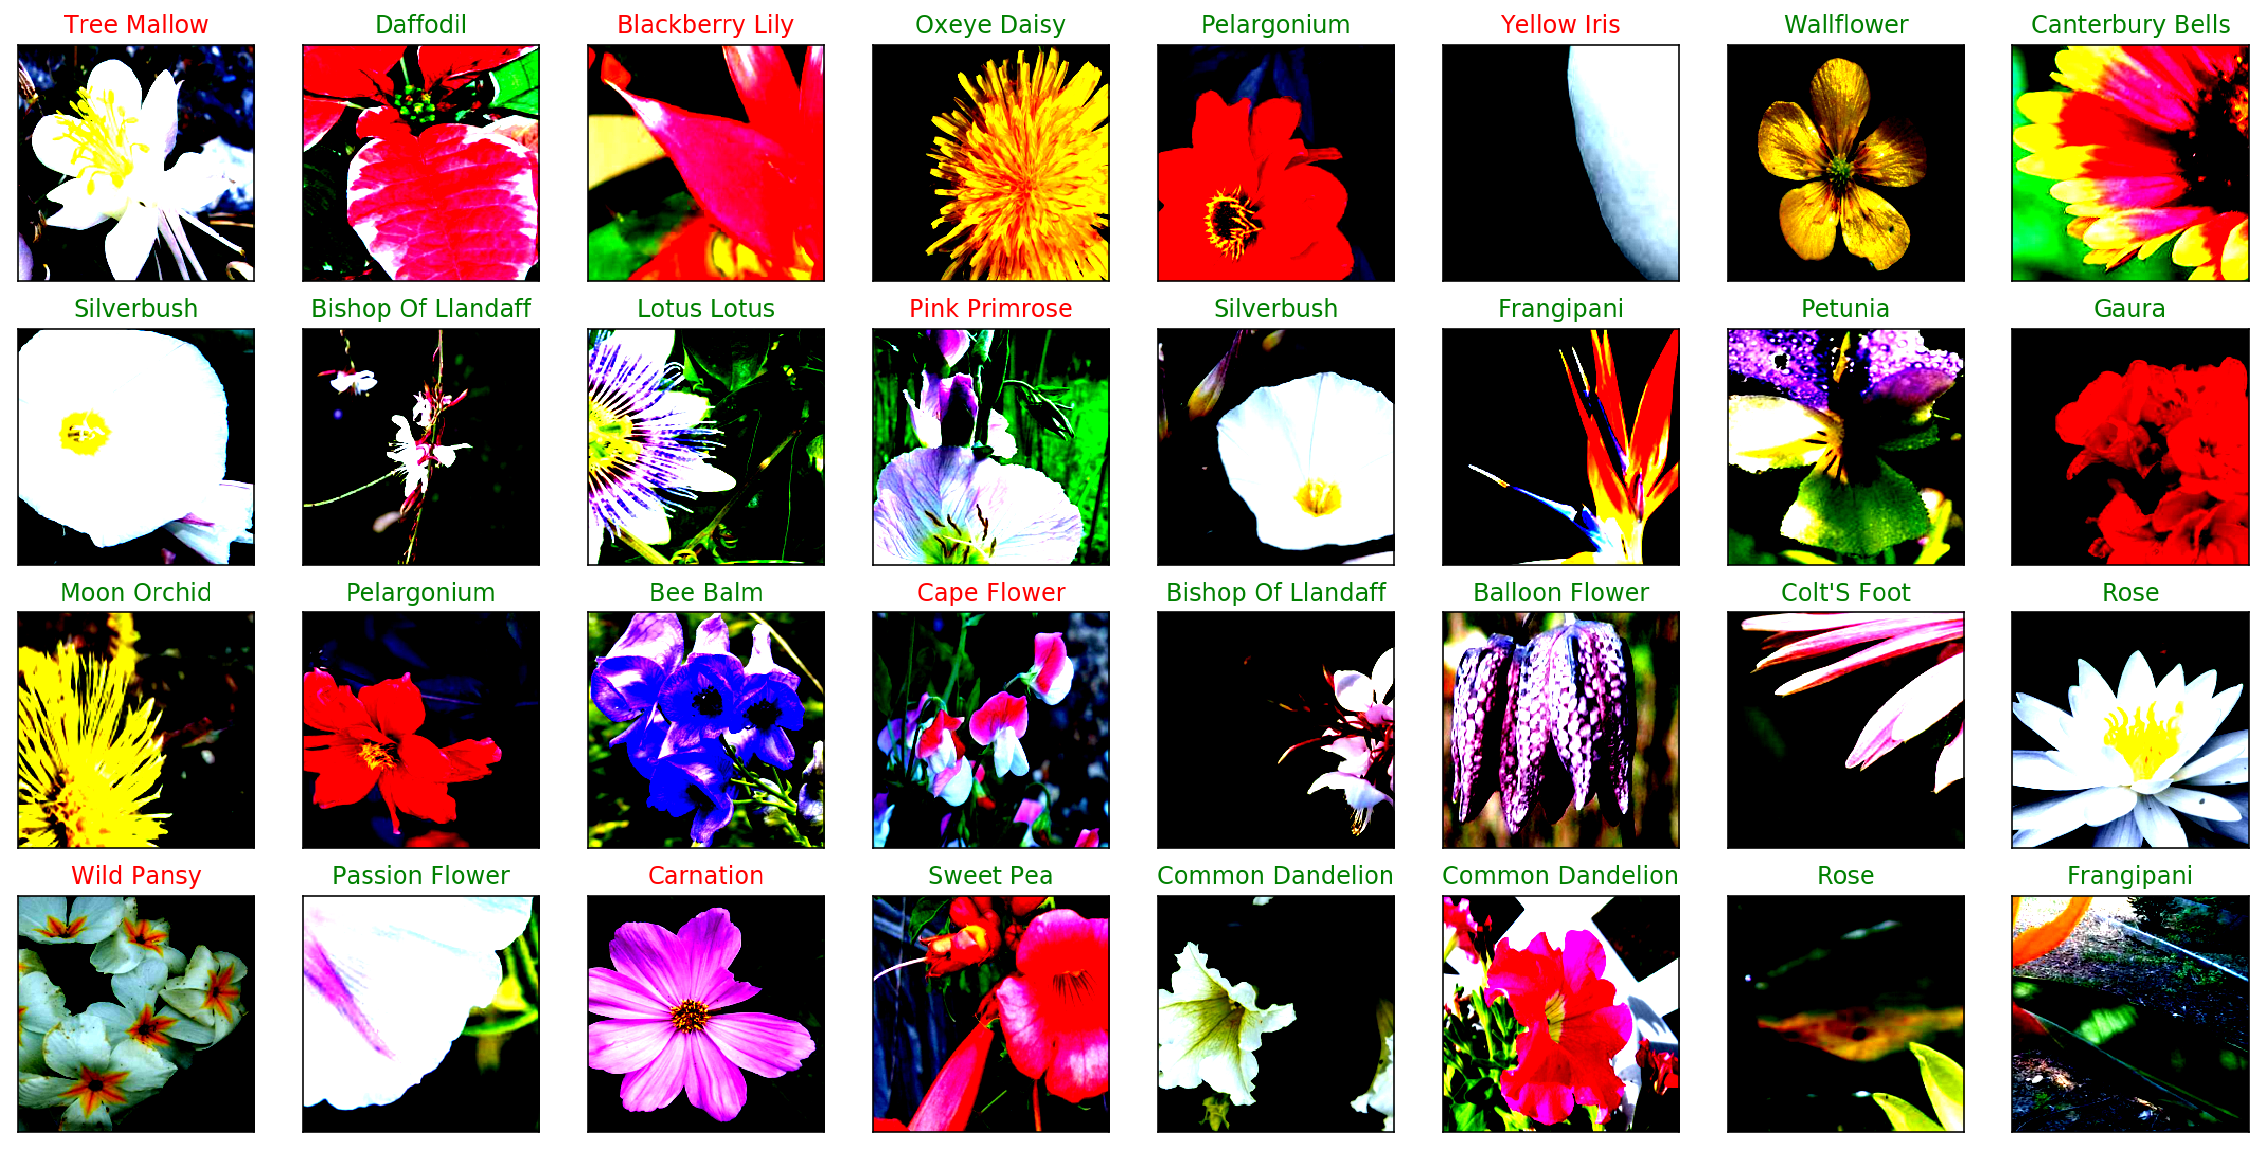

In [23]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# transer images and labels to the GPU if available 
images, labels = images.to(device), labels.to(device)

# obtain sample predictions 
logps = model(images)
ps = torch.exp(logps)

# obtain predicted classes
_, preds_tensor = torch.max(ps, 1)
preds = np.squeeze(preds_tensor.cpu().numpy()) 

# convert images to numpy for display
images = images.cpu().numpy() 
images = np.clip(images, 0, 1)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(32):
    ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{}".format(cat_to_name[str((labels[idx]+1).squeeze().cpu().numpy())].title()),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# [7] Apply model for inference

#### 7.1 Import and process the input image 
Next, we will pass an image into the network and predict the class of the flower in the image. However, we will first need to process the input image into a data set that can be used for inference with our model 

In [24]:
def process_image(image_path): 
    
    # open jpeg, convert color scales, resize the images where the shortest side is 256 pixels
    pil_image = Image.open(image_path).convert('RGB')
    
    # convert to numpy array, then normalize color channels, then convert back to PIl.Image
    #pil_image = ((np.array(pil_image)/255)).astype('float32')
        
    # transform and center crop image to 224 pixels 
    image_transform = transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # apply the transform and add the batch dimension
    pil_image = image_transform(pil_image)[:3,:,:].unsqueeze(0)
    
    return pil_image

In [25]:
image_path = 'mystery_flower_1.jpg'
processed_image = process_image(image_path)

#### 7.2 Verify input image processing
To confirm that the image was properly processed, next we will convert the image tensor to numpy array and displays it in the notebook (except for the cropped out portions)

In [26]:
def unprocess_image(image, ax=None, title=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension but matplotlib assumes is the third dimension
    image = image.view(3,224,224)
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo color channel normalization 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip image between 0 and 1, otherwise it will look like noise when displayed
    image = np.clip(image, 0, 1)
    
    # Display input image 
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

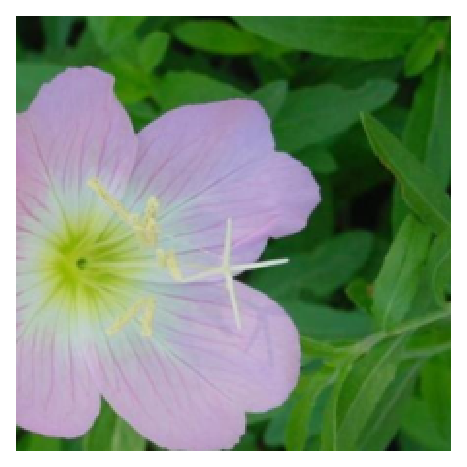

In [27]:
unprocess_image(processed_image);

#### 7.3 Predict the class (or classes) of the input image

In [38]:
def predict(image_path, model, topk):
   
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    
    # load and process the raw jpg image
    processed_image = process_image(image_path).cuda()
    
    # run the model forward in eval() mode
    with torch.no_grad():
        logps = model.eval().forward(processed_image)
    
    # calculate probabilities and top 5 classes from log probabilities output from the LogSoftmax function 
    ps = torch.exp(logps)
    top_p, top_class = ps.topk(topk, dim=1)
    
    return top_p, top_class

In [44]:
image_path = 'mystery_flower_1.jpg'
probs, classes = predict(image_path, model=model, topk=1)
print("%.0f%%" % (100 * probs.squeeze().cpu().numpy()), \
      'probability that it is a', cat_to_name[str((classes+1).squeeze().cpu().numpy())].title())

77% probability that it is a Pink Primrose


# `[8] Inference Sanity Check`

#### `8.1 Show top 10 class inference probabilities`

In [47]:
# run the prediction function for top 10 inferences
image_path = 'mystery_flower_1.jpg'
probs, classes = predict(image_path, model=model, topk=10)

# process output for display
probs = probs.squeeze().cpu().numpy()
classes = np.array(pd.Series([str(ii) for ii in list((classes+1).squeeze().cpu().numpy())]).map(cat_to_name).str.title())

# display results in a table
top_predictions = pd.DataFrame() 
top_predictions['Class'] = classes 
top_predictions['Probability'] = pd.Series(probs).map(lambda x: '{:.2%}'.format(x)).values 
top_predictions

Class Probability
0     Pink Primrose      77.22%
1     Spear Thistle      14.86%
2          Cyclamen       1.93%
3  Common Dandelion       1.68%
4         Sunflower       1.12%
5           Petunia       1.08%
6     Sweet William       0.40%
7         Columbine       0.31%
8   Trumpet Creeper       0.31%
9       Desert-Rose       0.17%

#### `8.2 Alternative visualization` 

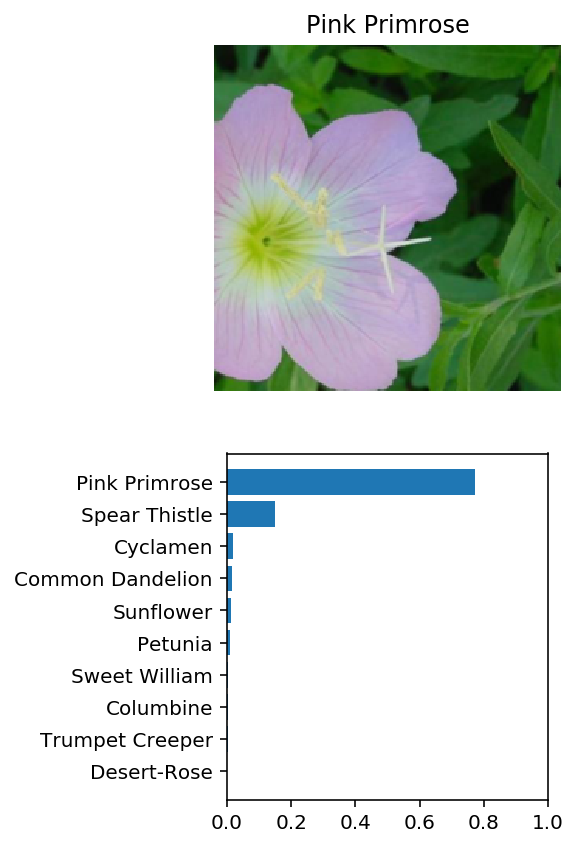

In [48]:
# obtain the center cropped image version used in the model in numpy for display  
image = process_image(image_path).view(3, 224, 224).numpy().transpose((1, 2, 0))
image = np.array([0.229, 0.224, 0.225]) * image + np.array([0.485, 0.456, 0.406])
image = np.clip(image, 0, 1)

# view image and prediction results
fig, (ax1, ax2) = plt.subplots(figsize=(9,6), nrows=2)
ax1.imshow(image) 
ax1.axis('off')
ax1.set_title(classes[0])
ax2.barh(np.arange(10), probs)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(classes)
ax2.invert_yaxis()
ax2.set_xlim(0, 1)

plt.tight_layout()